# Data Modeling & Model Evaluation – Uber Traffic Forecasting

### Importing Required Libraries

In [2]:

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

###  Load and Prepare Dataset

In [9]:
# Load the final preprocessed dataset
df = pd.read_csv("Final_Merged_Dataset.csv")

# Convert the 'DateTime' column to actual datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Sort the data chronologically to preserve time-based structure
df = df.sort_values('DateTime')

### Train-Test Split

In [4]:
# Define feature set (X) and target variable (y)
X = df.drop(columns=['DateTime', 'Date', 'ID', 'Vehicles']) # Exclude non-predictive columns
y = df['Vehicles']                                          # Target: standardized vehicle count

# Perform an 80/20 time-based split to simulate future predictions
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Train Gradient Boosting Model & Evaluate Performance

In [5]:
# Initialize the Gradient Boosting Regressor with basic hyperparameters
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)

# Train the model on the training data
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred = gbr.predict(X_test)

# Evaluate the model using common regression metrics
print("MAE:", mean_absolute_error(y_test, y_pred))                 # Mean Absolute Error
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))        # Root Mean Squared Error
print("R²:", r2_score(y_test, y_pred))                             # R-squared score

MAE: 0.2915095579712094
RMSE: 0.43761775323543217
R²: 0.8887521293107451


### Visual Evaluation of Model Predictions

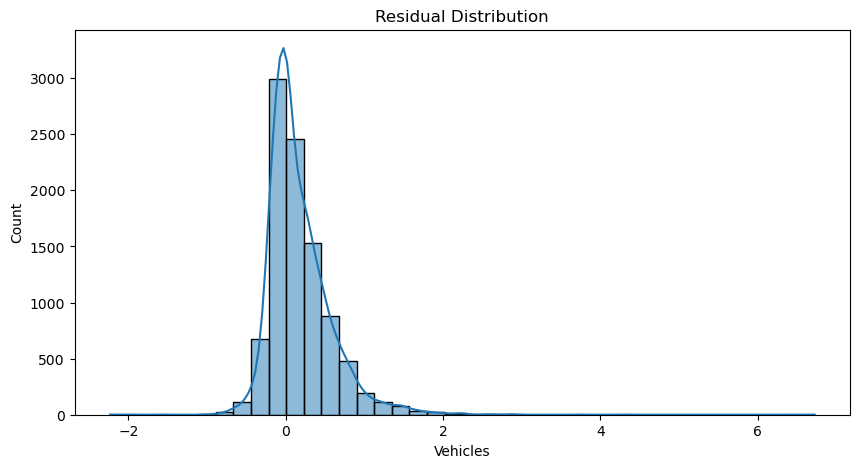

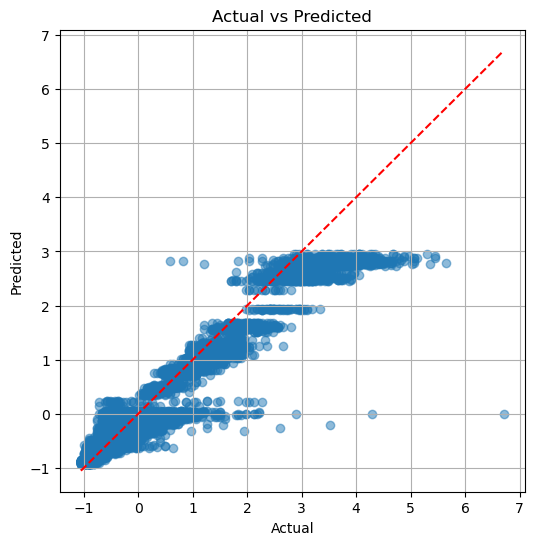

In [6]:
# Plot the distribution of residuals (prediction errors)

plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, bins=40, kde=True)
plt.title("Residual Distribution")
plt.show()



# Scatter plot of actual vs predicted vehicle counts
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Time Series Cross-Validation

In [7]:
# Initialize TimeSeriesSplit to preserve temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store metrics from each fold
mae_scores, rmse_scores, r2_scores = [], [], []

# Loop through each fold
for train_idx, test_idx in tscv.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
     # Train the model on training fold
    model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_tr, y_tr)

     # Predict on validation fold
    pred_val = model.predict(X_val)
    
    # Collect evaluation metrics 
    mae_scores.append(mean_absolute_error(y_val, pred_val))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, pred_val)))
    r2_scores.append(r2_score(y_val, pred_val))
    
# Print average cross-validation metrics
print("Average MAE:", np.mean(mae_scores))
print("Average RMSE:", np.mean(rmse_scores))
print("Average R²:", np.mean(r2_scores))

Average MAE: 0.34672442045006824
Average RMSE: 0.521962814644498
Average R²: 0.6480785131232428


### Model Refinement with GridSearchCV

In [8]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],   # Number of boosting stages
    'max_depth': [3, 5, 7]            # Maximum depth of individual regression estimators
}

# Set up GridSearchCV with TimeSeriesSplit to maintain temporal order
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best combination of hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Retrieve the best model and evaluate on test set
best_model = grid_search.best_estimator_
final_preds = best_model.predict(X_test)

# Evaluate the final model with optimal parameters
print("Final MAE:", mean_absolute_error(y_test, final_preds))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, final_preds)))
print("Final R²:", r2_score(y_test, final_preds))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'max_depth': 3, 'n_estimators': 150}
Final MAE: 0.3300165976594761
Final RMSE: 0.5131171347187472
Final R²: 0.8470551429327069
